# Mount Notebook to Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
FOLDERNAME = 'vaccine_data'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
PATH = '/content/drive/Shared drives/CS129_Milestone/{}'.format(FOLDERNAME)
sys.path.append(PATH)

%cd $PATH

Mounted at /content/drive
/content/drive/Shared drives/CS129_Milestone/vaccine_data


# Data Reading
We use the data for the first dose only. \
Data cleaning was already done (see Another_Milestone_0318 notebook).

In [ ]:
pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import hamming_loss
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from skmultilearn.model_selection import iterative_train_test_split

# XGBoost
from xgboost import XGBClassifier

In [ ]:
df_X= pd.read_csv('cleaned_data_0320.csv')
print(df_X.shape)
df_X.head()

(20622, 57)


,AstraZeneca,Covaxin,Moderna,Pfizer,Sinopharm,Sputnik,Sex,Age,Height,Weight,...,Covid_Symptom_11,Covid_Severity,Dose1_Fever,Dose1_Fatigue,Dose1_Headache,Dose1_Nausea,Dose1_Chills,Dose1_Joint_Pain,Dose1_Muscle_Pain,Dose1_Needle
0,1,0,0,0,0,0,0,33.0,164.0,56.0,...,0.0,0,0,0,1,0,0,0,0,1
1,1,0,0,0,0,0,0,33.0,164.0,56.0,...,0.0,0,0,0,1,0,0,0,0,1
2,1,0,0,0,0,0,0,41.0,156.0,70.0,...,0.0,0,0,1,1,0,0,1,1,1
3,1,0,0,0,0,0,0,62.0,157.0,65.0,...,0.0,0,0,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0,25.0,163.0,73.0,...,0.0,0,1,1,1,0,1,1,1,1


In [ ]:
X = df_X.iloc[:, :49]
y = df_X.iloc[:, 49:]

In [ ]:
# Stratified split into train/test sets
X_train, y_train, X_test, y_test = iterative_train_test_split(np.array(X), np.array(y), test_size = 0.25)

# Make the results pd.DataFrames
X_column_values = list(X.columns)
y_column_values = list(y.columns)
X_train = pd.DataFrame(data = X_train,  
                  columns = X_column_values)
X_test = pd.DataFrame(data = X_test,  
                  columns = X_column_values)
y_train = pd.DataFrame(data = y_train,  
                  columns = y_column_values)
y_test = pd.DataFrame(data = y_test,  
                  columns = y_column_values)

# Confirm the dimensions of the split data
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15466, 49) (15466, 8)
(5156, 49) (5156, 8)


In [ ]:
# Normalize continuous features using StandardScaler
scaler = StandardScaler()
X_train.iloc[:, 7:10] = scaler.fit_transform(X_train.iloc[:, 7:10])
X_test.iloc[:, 7:10] = scaler.transform(X_test.iloc[:, 7:10])

---
# Decision Trees



In [ ]:
# Build the decision tree model (using OvR method)
# Trains single decision tree for each class, and first determine the best tree depth
import matplotlib.pyplot as plt

def one_versus_all(X, y):
    kf = KFold(n_splits=5, random_state=3, shuffle=True)
    
    # Averages for cv data, not training data 
    avg_hamming = []
    avg_precision = []
    avg_recall = []
    avg_f1score = []

    for i in [10, 20, 30, 40, 50, 60, 70]:
      hamming_loss_train_arr = []
      hamming_loss_cv_arr = []
      precision_train_arr = []
      precision_cv_arr = []
      recall_train_arr = []
      recall_cv_arr = []
      f1score_train_arr = []
      f1score_cv_arr = []
      for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]       # Train data
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]       # CV data
          
        # Build the one versus all classifiers (decision tree)
        # (need to choose the best depth)
        dtc = DecisionTreeClassifier(max_depth=i, class_weight='balanced')
        clf = OneVsRestClassifier(dtc).fit(X_train, y_train)

        y_pred_train = clf.predict(X_train)
        y_pred_cv = clf.predict(X_test)
        #f1_score_train = f1_score(y_train, y_pred_train, average = 'micro')
        #f1_score_cv = f1_score(y_test, y_pred_cv, average = 'micro')
        hamming_loss_train = hamming_loss(y_train, y_pred_train)
        hamming_loss_cv = hamming_loss(y_test, y_pred_cv)
        macro_precision_train, macro_recall_train, macro_f1score_train, _ = precision_recall_fscore_support(y_train, y_pred_train, average='macro')
        macro_precision_cv, macro_recall_cv, macro_f1score_cv, _ = precision_recall_fscore_support(y_test, y_pred_cv, average='macro')

        hamming_loss_train_arr.append(hamming_loss_train)
        hamming_loss_cv_arr.append(hamming_loss_cv)
        precision_train_arr.append(macro_precision_train)
        precision_cv_arr.append(macro_precision_cv)
        recall_train_arr.append(macro_recall_train)
        recall_cv_arr.append(macro_recall_cv)
        f1score_train_arr.append(macro_f1score_train)
        f1score_cv_arr.append(macro_f1score_cv)
          
      # print('Max Depth:', i, 'Hamming Loss Train:', np.mean(hamming_loss_train_arr), 'Hamming Loss CV:', np.mean(hamming_loss_cv_arr))
      # print('----------------', 'Precision Train:', np.mean(precision_train_arr), 'Precision CV:', np.mean(precision_cv_arr))
      # print('----------------', 'Recall Train:', np.mean(recall_train_arr), 'Recall CV:', np.mean(recall_cv_arr))      
      # print('----------------', 'F1 Score Train:', np.mean(f1score_train_arr), 'F1 Score CV:', np.mean(f1score_cv_arr)) 

      avg_hamming.append(np.mean(hamming_loss_cv_arr))
      avg_precision.append(np.mean(precision_cv_arr))
      avg_recall.append(np.mean(recall_cv_arr))
      avg_f1score.append(np.mean(f1score_cv_arr))
    
    # plot average hamming loss, precision, recall, and f1score for each depth value 
    #depths = np.arange(3, 15)
    depths = [10, 20, 30, 40, 50, 60, 70]


    # Initialise the subplot function using number of rows and columns
    figure, axis = plt.subplots(2, 2)

    axis[0, 0].plot(depths, avg_hamming, color="red")
    axis[0, 0].set_title("Hamming Loss By Max Depth")
    # axis[0, 0].set_xlabel("Max Depth")
    axis[0, 0].set_ylabel("Hamming Loss") 
      
    axis[0, 1].plot(depths, avg_precision, color="blue")
    axis[0, 1].set_title("Precision By Max Depth")
    # axis[0, 1].set_xlabel("Max Depth")
    axis[0, 1].set_ylabel("Precision")

    axis[1, 0].plot(depths, avg_recall, color="green")
    axis[1, 0].set_title("Recall By Max Depth")
    axis[1, 0].set_xlabel("Max Depth")
    axis[1, 0].set_ylabel("Recall") 
    
    axis[1, 1].plot(depths, avg_f1score, color="black")
    axis[1, 1].set_title("F1 Score By Max Depth")
    axis[1, 1].set_xlabel("Max Depth")
    axis[1, 1].set_ylabel("F1 Score") 
    
    # Combine all the operations and display
    figure.tight_layout(pad=2.0)
    plt.show()

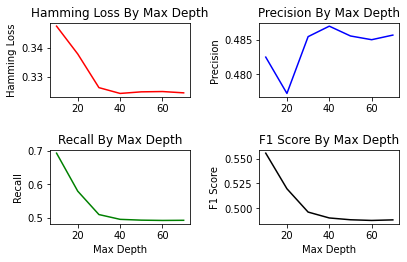

In [ ]:
# Run the decision tree algorithm 
one_versus_all(X_train, y_train)

Here we can see that the best performing model has depth 10. 

In [ ]:
# Train a decision tree with depth 10 on all the training data 

dtc = DecisionTreeClassifier(max_depth=10, class_weight='balanced')
clf = OneVsRestClassifier(dtc).fit(X_train, y_train)

y_pred_test = clf.predict(X_test)

# Get hamming loss, precision, recall, F1 score, and ROC-AUC for the test data 
hamming_loss_test = hamming_loss(y_test, y_pred_test)
micro_precision_test, micro_recall_test, micro_f1score_test, _ = precision_recall_fscore_support(y_test, y_pred_test, average='micro')
roc_auc_test = roc_auc_score(y_test, y_pred_test, average='micro', multi_class='ovr')

print("Hamming Loss (Test): ", hamming_loss_test)
print("Micro Precision (Test): ", micro_precision_test)
print("Micro Recall (Test): ", micro_recall_test)
print("Micro F1 Score (Test): ", micro_f1score_test)
print("ROC AUC (Test):", roc_auc_test)

# Use this to find all precision, recall, and F1 score
print(classification_report(y_test, y_pred_test, target_names=['Dose1_Fever', 'Dose1_Fatigue', 'Dose1_Headache', 'Dose1_Nausea', 'Dose1_Chills', 'Dose1_Joint_Pain', 'Dose1_Muscle_Pain', 'Dose1_Needle'], digits=4, zero_division=0))



Hamming Loss (Test):  0.3504654771140419
Micro Precision (Test):  0.4987403191191565
Micro Recall (Test):  0.7422580197194834
Micro F1 Score (Test):  0.5966067641477844
ROC AUC (Test): 0.6635653471289152
                   precision    recall  f1-score   support

      Dose1_Fever     0.5083    0.8130    0.6255      1626
    Dose1_Fatigue     0.6407    0.6368    0.6388      2638
   Dose1_Headache     0.4724    0.7494    0.5795      1744
     Dose1_Nausea     0.1719    0.6969    0.2758       518
     Dose1_Chills     0.4612    0.8766    0.6045      1378
 Dose1_Joint_Pain     0.4176    0.7706    0.5417      1447
Dose1_Muscle_Pain     0.5411    0.7379    0.6244      2053
     Dose1_Needle     0.6704    0.7278    0.6979      2998

        micro avg     0.4987    0.7423    0.5966     14402
        macro avg     0.4854    0.7511    0.5735     14402
     weighted avg     0.5409    0.7423    0.6143     14402
      samples avg     0.3658    0.5161    0.3898     14402



---
# XGBoost







In [ ]:
# Tunes the parameters for each label individually AND evaluates the models

# define a list of the labels to tune for
labels = ['Dose1_Fever', 'Dose1_Fatigue', 'Dose1_Headache', 'Dose1_Nausea', 'Dose1_Chills', 'Dose1_Joint_Pain', 'Dose1_Muscle_Pain', 'Dose1_Needle']

models = {}
y_pred_arr = np.zeros_like(y_test)

# Loop over each label and train a separate XGBoost model for that label
i = 0
for label in labels:
    print(f'Training model for {label}')

    # Create a new XGBoost classifier instance for this label
    model = XGBClassifier(objective='binary:logistic', random_state=1)

    # Good value for scale_pos_weight: count(negative examples) / count(positive examples)
    pos = sum(y_test[label])
    neg = len(y_test[label]) - pos
    scale_weight = neg / pos
    
    # (1) Tune the max_depth hyperparameter for this label using GridSearchCV
    param_grid = {
      'max_depth': [10, 30, 50, 70],
      'scale_pos_weight': [scale_weight] }     # Control the balance of positive and negative weights, useful for unbalanced classes.
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train[label])
    best_params = grid_search.best_params_

    # (2) Tune the learning_rate hyperparameter for this label using GridSearchCV
    param_grid2 = {
      'max_depth': [best_params['max_depth']],          # Get the best max depth from the previous gridsearch
      'scale_pos_weight': [scale_weight],                              
      'learning_rate': [0.01, 0.1, 0.15, 0.3] }    
    grid_search2 = GridSearchCV(model, param_grid2, cv=5, scoring='accuracy')
    grid_search2.fit(X_train, y_train[label])
    best_params2 = grid_search2.best_params_

    # (3) Tune the n_estimators hyperparameter for this label using GridSearchCV
    param_grid3 = {
      'max_depth': [best_params2['max_depth']],          # Get the best max depth from the first gridsearch
      'scale_pos_weight': [scale_weight],                              
      'learning_rate': [best_params2['learning_rate']],  # Get the best learning rate from the second gridsearch
      'n_estimators': [50, 100, 150, 200] }              # Specifies the number of trees 
    grid_search3 = GridSearchCV(model, param_grid3, cv=5, scoring='accuracy')
    grid_search3.fit(X_train, y_train[label])

    # Store the best model and its parameters (learning_rate)
    best_params3 = grid_search3.best_params_
    best_model3 = grid_search3.best_estimator_
    models[label] = {'model': best_model3, 'params': best_params3}
    
    # Store the prediction from the test set
    y_pred = best_model3.predict(X_test)
    y_pred_arr[:, i] = y_pred
    i = i+1

# Print the best parameters for each model
for label, model_info in models.items():
    print(f'Best parameters for {label}: {model_info["params"]}')

# Evaluate the model with the test data (precision, recall, f1 scores, hamming loss, ROC-AUC)
print(classification_report(y_test, y_pred_arr, target_names=['Dose1_Fever', 'Dose1_Fatigue', 'Dose1_Headache', 'Dose1_Nausea', 'Dose1_Chills', 'Dose1_Joint_Pain', 'Dose1_Muscle_Pain', 'Dose1_Needle'], digits=4, zero_division=0))
print('Hamming Loss: ', hamming_loss(y_test, y_pred_arr))
roc_auc_test = roc_auc_score(y_test, y_pred_test, average='micro', multi_class='ovr')



Training model for Dose1_Fever
Training model for Dose1_Fatigue
Training model for Dose1_Headache
Training model for Dose1_Nausea
Training model for Dose1_Chills
Training model for Dose1_Joint_Pain
Training model for Dose1_Muscle_Pain
Training model for Dose1_Needle
Best parameters for Dose1_Fever: {'learning_rate': 0.15, 'max_depth': 30, 'n_estimators': 200, 'scale_pos_weight': 2.1709717097170973}
Best parameters for Dose1_Fatigue: {'learning_rate': 0.15, 'max_depth': 10, 'n_estimators': 50, 'scale_pos_weight': 0.954510993176649}
Best parameters for Dose1_Headache: {'learning_rate': 0.3, 'max_depth': 50, 'n_estimators': 100, 'scale_pos_weight': 1.9564220183486238}
Best parameters for Dose1_Nausea: {'learning_rate': 0.3, 'max_depth': 30, 'n_estimators': 200, 'scale_pos_weight': 8.953667953667953}
Best parameters for Dose1_Chills: {'learning_rate': 0.15, 'max_depth': 50, 'n_estimators': 100, 'scale_pos_weight': 2.741654571843251}
Best parameters for Dose1_Joint_Pain: {'learning_rate': 0

In [ ]:
# Create an empty dataframe with columns for the label, max_depth, and scale_pos_weight
df_params = pd.DataFrame(columns=['label', 'max_depth', 'n_estimators', 'learning_rate', 'scale_pos_weight'])

# Iterate through the models dictionary and extract the best parameters for each label
for label, model_info in models.items():
    best_params = model_info['params']    
    # Append the label and best parameters to the dataframe
    df = pd.DataFrame({'label': [label], 
                       'max_depth': [best_params['max_depth']], 
                       'n_estimators': [best_params['n_estimators']], 
                       'learning_rate': [best_params['learning_rate']], 
                       'scale_pos_weight': [best_params['scale_pos_weight']]})
    df_params = pd.concat([df_params, df], ignore_index=True)
    
# Print the resulting dataframe
display(df_params)

# Evaluate the model with the test data (precision, recall, f1 scores, hamming loss, ROC-AUC)
print(classification_report(y_test, y_pred_arr, target_names=['Dose1_Fever', 'Dose1_Fatigue', 'Dose1_Headache', 'Dose1_Nausea', 'Dose1_Chills', 'Dose1_Joint_Pain', 'Dose1_Muscle_Pain', 'Dose1_Needle'], digits=4, zero_division=0))
print('Hamming Loss: ', hamming_loss(y_test, y_pred_arr))
print('ROC-AUC score: ', roc_auc_score(y_test, y_pred_arr, average='micro', multi_class='ovr'))

eval_report = classification_report(y_test, y_pred_arr, output_dict = True, target_names=['Dose1_Fever', 'Dose1_Fatigue', 'Dose1_Headache', 'Dose1_Nausea', 'Dose1_Chills', 'Dose1_Joint_Pain', 'Dose1_Muscle_Pain', 'Dose1_Needle'], digits=4, zero_division=0)
pd.DataFrame(eval_report).transpose()




,label,max_depth,n_estimators,learning_rate,scale_pos_weight
0,Dose1_Fever,30,200,0.15,2.170972
1,Dose1_Fatigue,10,50,0.15,0.954511
2,Dose1_Headache,50,100,0.30,1.956422
3,Dose1_Nausea,30,200,0.30,8.953668
4,Dose1_Chills,50,100,0.15,2.741655
5,Dose1_Joint_Pain,30,150,0.30,2.563234
6,Dose1_Muscle_Pain,70,150,0.10,1.511447
7,Dose1_Needle,10,100,0.15,0.719813


                   precision    recall  f1-score   support

      Dose1_Fever     0.5856    0.6458    0.6142      1626
    Dose1_Fatigue     0.6554    0.7180    0.6852      2638
   Dose1_Headache     0.5465    0.5057    0.5253      1744
     Dose1_Nausea     0.3312    0.3050    0.3176       518
     Dose1_Chills     0.5381    0.6103    0.5719      1378
 Dose1_Joint_Pain     0.4853    0.4921    0.4887      1447
Dose1_Muscle_Pain     0.5933    0.6366    0.6142      2053
     Dose1_Needle     0.6992    0.7605    0.7286      2998

        micro avg     0.5976    0.6335    0.6150     14402
        macro avg     0.5543    0.5842    0.5682     14402
     weighted avg     0.5946    0.6335    0.6129     14402
      samples avg     0.4334    0.4629    0.4059     14402

Hamming Loss:  0.2769103956555469
ROC-AUC score:  0.7023311057054652


,precision,recall,f1-score,support
Dose1_Fever,0.585611,0.645756,0.614215,1626.0
Dose1_Fatigue,0.655363,0.717968,0.685239,2638.0
Dose1_Headache,0.546468,0.505734,0.525313,1744.0
Dose1_Nausea,0.331237,0.305019,0.317588,518.0
Dose1_Chills,0.538068,0.610305,0.571914,1378.0
Dose1_Joint_Pain,0.485344,0.492053,0.488675,1447.0
Dose1_Muscle_Pain,0.593282,0.636629,0.614192,2053.0
Dose1_Needle,0.699172,0.760507,0.728551,2998.0
micro avg,0.597590,0.633523,0.615032,14402.0
macro avg,0.554318,0.584246,0.568211,14402.0


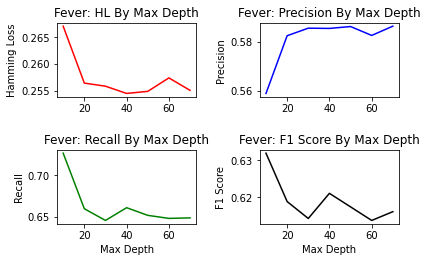

In [ ]:
# Max Depth
# Goal: graph the HL, precision, recall, F1 scores against different xgboost parameters 
# Since we used OvR classification, we'll just choose one of the 8 classifiers we built (say, Fever)

# Good value for scale_pos_weight: count(negative examples) / count(positive examples)
label = 'Dose1_Fever'
pos = sum(y_test[label])
neg = len(y_test[label]) - pos
scale_weight = neg / pos


hamming_loss_test_arr = []
precision_test_arr = []
recall_test_arr = []
f1score_test_arr = []

for i in [10, 20, 30, 40, 50, 60, 70]:

  # Create a new XGBoost classifier instance for this label
  model = XGBClassifier(objective='binary:logistic', random_state=2,
                        max_depth = i,
                        scale_pos_weight = scale_weight,
                        learning_rate = 0.15,
                        n_estimators = 200)
  clf = model.fit(X_train, y_train[label])
  y_pred = clf.predict(X_test)

  hamming_loss_test = hamming_loss(y_test[label], y_pred)
  precision_test, recall_test, f1score_test, _ = precision_recall_fscore_support(y_test[label], y_pred, average='binary')

  hamming_loss_test_arr.append(hamming_loss_test)
  precision_test_arr.append(precision_test)
  recall_test_arr.append(recall_test)
  f1score_test_arr.append(f1score_test)
  
  
# plot average hamming loss, precision, recall, and f1score for each depth value 
depths = [10, 20, 30, 40, 50, 60, 70]

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2)

axis[0, 0].plot(depths, hamming_loss_test_arr, color="red")
axis[0, 0].set_title("Fever: HL By Max Depth")
# axis[0, 0].set_xlabel("Max Depth")
axis[0, 0].set_ylabel("Hamming Loss") 
  
axis[0, 1].plot(depths, precision_test_arr, color="blue")
axis[0, 1].set_title("Fever: Precision By Max Depth")
# axis[0, 1].set_xlabel("Max Depth")
axis[0, 1].set_ylabel("Precision")

axis[1, 0].plot(depths, recall_test_arr, color="green")
axis[1, 0].set_title("Fever: Recall By Max Depth")
axis[1, 0].set_xlabel("Max Depth")
axis[1, 0].set_ylabel("Recall") 

axis[1, 1].plot(depths, f1score_test_arr, color="black")
axis[1, 1].set_title("Fever: F1 Score By Max Depth")
axis[1, 1].set_xlabel("Max Depth")
axis[1, 1].set_ylabel("F1 Score") 

# Combine all the operations and display
figure.tight_layout(pad=2.0)
plt.show()

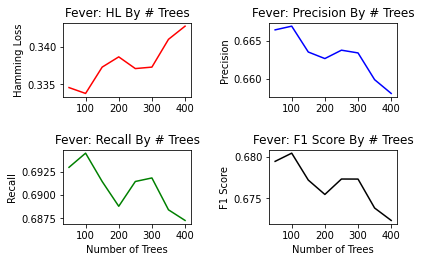

In [ ]:
# n_estimators (number of trees)
# Goal: graph the HL, precision, recall, F1 scores against different xgboost parameters 
# Since we used OvR classification, we'll just choose one of the 8 classifiers we built (say, Fever)

# Good value for scale_pos_weight: count(negative examples) / count(positive examples)
label = 'Dose1_Fatigue'
pos = sum(y_test[label])
neg = len(y_test[label]) - pos
scale_weight = neg / pos


hamming_loss_test_arr = []
precision_test_arr = []
recall_test_arr = []
f1score_test_arr = []

for i in [50, 100, 150, 200, 250, 300, 350, 400]:

  # Create a new XGBoost classifier instance for this label
  model = XGBClassifier(objective='binary:logistic', random_state=3,
                        max_depth = 30,
                        scale_pos_weight = scale_weight,
                        learning_rate = 0.15,
                        n_estimators = i)
  clf = model.fit(X_train, y_train[label])
  y_pred = clf.predict(X_test)

  hamming_loss_test = hamming_loss(y_test[label], y_pred)
  precision_test, recall_test, f1score_test, _ = precision_recall_fscore_support(y_test[label], y_pred, average='binary')

  hamming_loss_test_arr.append(hamming_loss_test)
  precision_test_arr.append(precision_test)
  recall_test_arr.append(recall_test)
  f1score_test_arr.append(f1score_test)
  
  
# plot average hamming loss, precision, recall, and f1score for each depth value 
n_trees = [50, 100, 150, 200, 250, 300, 350, 400]

# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2)

axis[0, 0].plot(n_trees, hamming_loss_test_arr, color="red")
axis[0, 0].set_title("Fever: HL By # Trees")
# axis[0, 0].set_xlabel("Number of Trees")
axis[0, 0].set_ylabel("Hamming Loss") 
  
axis[0, 1].plot(n_trees, precision_test_arr, color="blue")
axis[0, 1].set_title("Fever: Precision By # Trees")
# axis[0, 1].set_xlabel("Number of Trees")
axis[0, 1].set_ylabel("Precision")

axis[1, 0].plot(n_trees, recall_test_arr, color="green")
axis[1, 0].set_title("Fever: Recall By # Trees")
axis[1, 0].set_xlabel("Number of Trees")
axis[1, 0].set_ylabel("Recall") 

axis[1, 1].plot(n_trees, f1score_test_arr, color="black")
axis[1, 1].set_title("Fever: F1 Score By # Trees")
axis[1, 1].set_xlabel("Number of Trees")
axis[1, 1].set_ylabel("F1 Score") 

# Combine all the operations and display
figure.tight_layout(pad=2.0)
plt.show()